<a href="https://colab.research.google.com/github/jg4726/public-file/blob/main/Cnn_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os # processing file path
import gzip # unzip the .gz file, not used here
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
'''
from subprocess import check_output
print("Here are the input datasets: ")
print(check_output(["ls", "../input"]).decode("utf8"))
'''

print("Python Version: ")
!python -V
# Any results you write to the current directory are saved as output.

Python Version: 
Python 3.7.12


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#load the GZ file in G drive
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind) 
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

Clear previously loaded data.


In [ ]:
# Load the data
X_train, y_train = load_mnist('/content/drive/MyDrive/6613', kind='train')
X_test, y_test = load_mnist('/content/drive/MyDrive/6613', kind='t10k')
m_train = X_train.shape[0]
m_test = X_test.shape[0]

In [ ]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
Number of training examples: m_train = 60000
Number of testing examples: m_test = 10000


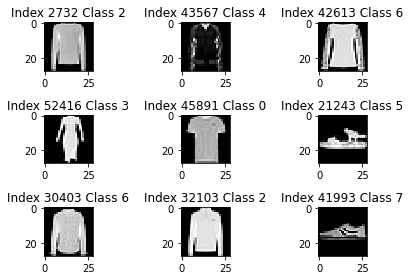

In [ ]:
# random check with nine training examples
np.random.seed(0);
indices = list(np.random.randint(m_train,size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [ ]:
# Subsample the data
m_train = 59000
m_validation = 1000

mask = list(range(m_train, m_train + m_validation))
X_val = X_train[mask]
y_val = y_train[mask]

mask = list(range(m_train))
X_train = X_train[mask]
y_train = y_train[mask]

mask = list(range(m_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape data to rows
X_train = X_train.reshape(m_train, -1)
X_val = X_val.reshape(m_validation, -1)
X_test = X_test.reshape(m_test, -1)

In [ ]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of validation examples: m_validation = " + str(m_validation))
print ("Number of testing examples: m_test = " + str(m_test))

X_train shape: (59000, 784)
y_train shape: (59000,)
X_val shape: (1000, 784)
y_val shape: (1000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
Number of training examples: m_train = 59000
Number of validation examples: m_validation = 1000
Number of testing examples: m_test = 10000


In [ ]:
print("Feature Values: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))
print("Data type: " + str(X_train.dtype))
print("\nLabel Values: ")
print(set(list(y_train)))
print("Data type: " + str(y_train.dtype))

Feature Values: 
From 0 to 255
Data type: uint8

Label Values: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Data type: uint8


In [ ]:
class TwoLayerNet(object):    
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4): 
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}    
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)   
        self.params['b1'] = np.zeros((1, hidden_size))    
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)   
        self.params['b2'] = np.zeros((1, output_size))

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        # Compute the forward pass
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)      
        out = np.dot(h1, W2) + b2          
        scores = out
        
        # If the targets are not given then jump out, we're done
        if y is None:   
            return scores
        
        # Compute the loss
        scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1)
        exp_scores = np.exp(scores - scores_max)              # (N,C)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    # (N,C)
        correct_logprobs = -np.log(probs[range(N), y])        # (N,1)
        data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1*W1) + 0.5 * reg * np.sum(W2*W2)
        loss = data_loss + reg_loss
        
        # Backward pass: compute gradients
        grads = {}
        dscores = probs                                 # (N,C)
        dscores[range(N), y] -= 1
        dscores /= N
        dW2 = np.dot(h1.T, dscores)                     # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        dh1[h1 <= 0] = 0
        dW1 = np.dot(X.T, dh1)                          # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
        dW2 += reg * W2
        dW1 += reg * W1
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads

    def train(self, X, y, X_val, y_val, learning_rate=1e-3, 
               learning_rate_decay=0.95, reg=1e-5, mu=0.9, num_epochs=10, 
               mu_increase=1.0, batch_size=200, verbose=False):   
        """
        Train this neural network using stochastic gradient descent.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1)
        
        # Use SGD to optimize the parameters in self.model
        v_W2, v_b2 = 0.0, 0.0
        v_W1, v_b1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(1, num_epochs * iterations_per_epoch + 1):   
            X_batch = None   
            y_batch = None 
            
            # Create a random minibatch of training data and labels
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]          
            y_batch = y[sample_index]             
            
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg) 
            loss_history.append(loss)
            
            # Use the gradients to update the parameters of the network
            v_W2 = mu * v_W2 - learning_rate * grads['W2']    
            self.params['W2'] += v_W2   
            v_b2 = mu * v_b2 - learning_rate * grads['b2']    
            self.params['b2'] += v_b2   
            v_W1 = mu * v_W1 - learning_rate * grads['W1']    
            self.params['W1'] += v_W1   
            v_b1 = mu * v_b1 - learning_rate * grads['b1']  
            self.params['b1'] += v_b1
            
            if verbose and it % iterations_per_epoch == 0:    
            # Every epoch, check train and val accuracy and decay learning rate.
                epoch = it / iterations_per_epoch    
                train_acc = (self.predict(X_batch) == y_batch).mean()    
                val_acc = (self.predict(X_val) == y_val).mean()    
                train_acc_history.append(train_acc)    
                val_acc_history.append(val_acc)    
                print("epoch %d / %d: loss %f, train_acc: %f, val_acc: %f" % 
                                    (epoch, num_epochs, loss, train_acc, val_acc))
                
                # Decay learning rate
                learning_rate *= learning_rate_decay    
                mu *= mu_increase

        return {   
            'loss_history': loss_history,   
            'train_acc_history': train_acc_history,   
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):    
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None    
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])    
        scores = np.dot(h1, self.params['W2']) + self.params['b2']    
        y_pred = np.argmax(scores, axis=1)    

        return y_pred

def ReLU(x):    
     
    return np.maximum(0, x)

In [ ]:
input_size = X_train.shape[1]
hidden_size = 10
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_epochs=10, batch_size=1024,
            learning_rate=7.5e-4, learning_rate_decay=0.95,
            reg=1.0, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 10: loss 0.828701, train_acc: 0.740234, val_acc: 0.745000
epoch 2 / 10: loss 0.676372, train_acc: 0.807617, val_acc: 0.810000
epoch 3 / 10: loss 0.596384, train_acc: 0.815430, val_acc: 0.817000
epoch 4 / 10: loss 0.642097, train_acc: 0.805664, val_acc: 0.829000
epoch 5 / 10: loss 0.568895, train_acc: 0.854492, val_acc: 0.840000
epoch 6 / 10: loss 0.606983, train_acc: 0.821289, val_acc: 0.832000
epoch 7 / 10: loss 0.621183, train_acc: 0.833008, val_acc: 0.828000
epoch 8 / 10: loss 0.603119, train_acc: 0.827148, val_acc: 0.845000
epoch 9 / 10: loss 0.614114, train_acc: 0.833984, val_acc: 0.823000
epoch 10 / 10: loss 0.617055, train_acc: 0.852539, val_acc: 0.842000


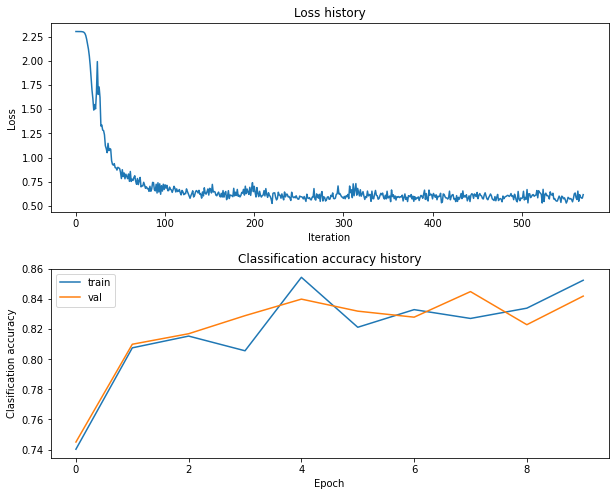

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(wspace =0, hspace =0.3)


# Plot the loss function and train / validation accuracies

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [ ]:
# Fine-tune hyperparameters such as learning_rates and regularization_strengths
# To find the best_net for predicting on the test (It takes about 1~3 minutes depends on CPU)
# Other hyperparameters: hidden_size / num_epochs / ...

hidden_size = 10
num_classes = 10

results = {}
best_val = -1
best_net = None

learning_rates = np.array([2.5,5,7.5,10])*1e-4
regularization_strengths = [0.25,0.5,0.75,1]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        stats = net.train(X_train, y_train, X_val, y_val,
        num_epochs=10, batch_size=1024,
        learning_rate=lr, learning_rate_decay=0.95,
        reg= reg, verbose=False)
        val_acc = (net.predict(X_val) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc


for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg,  val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.500000e-04 reg 2.500000e-01 val accuracy: 0.851000
lr 2.500000e-04 reg 5.000000e-01 val accuracy: 0.841000
lr 2.500000e-04 reg 7.500000e-01 val accuracy: 0.857000
lr 2.500000e-04 reg 1.000000e+00 val accuracy: 0.825000
lr 5.000000e-04 reg 2.500000e-01 val accuracy: 0.847000
lr 5.000000e-04 reg 5.000000e-01 val accuracy: 0.837000
lr 5.000000e-04 reg 7.500000e-01 val accuracy: 0.840000
lr 5.000000e-04 reg 1.000000e+00 val accuracy: 0.833000
lr 7.500000e-04 reg 2.500000e-01 val accuracy: 0.841000
lr 7.500000e-04 reg 5.000000e-01 val accuracy: 0.835000
lr 7.500000e-04 reg 7.500000e-01 val accuracy: 0.820000
lr 7.500000e-04 reg 1.000000e+00 val accuracy: 0.825000
lr 1.000000e-03 reg 2.500000e-01 val accuracy: 0.856000
lr 1.000000e-03 reg 5.000000e-01 val accuracy: 0.847000
lr 1.000000e-03 reg 7.500000e-01 val accuracy: 0.783000
lr 1.000000e-03 reg 1.000000e+00 val accuracy: 0.746000
best validation accuracy achieved during cross-validation: 0.857000
